# Mandatory Assignment 4
## Submission Deadline: 1st March, 2022

#### Reinforcement Learning and Decision Making Under Uncertainty IN-STK 5100/9100, Spring 2022, UiO
#### A. George, 15th February, 2022

## Description:
In this exercise, we will compare different $k$-armed bandit strategies on the 10-armed testbed. \
Remember to **only fill in the marked gaps** and do not modify any other bits of code (except trying different parameters)!\
There are experiments provided at the end with which you can **verify that your code is running correctly**.

Let's start!

#### Some Notation:
- $k$ number of arms
- $T$ time horizon
- $t=0,...T-1$ time steps
- $A_t$ arm selected in round $t$
- $R_t$ reward received after pulling arm $A_t$
- $N^{t+1}(a)$ the number of pulls of arm $a$ until (non-inclusive) round $t$
- $Q^{t+1}(a)$ the estimated value of arm $a$ after round $t$
- $Q^{0}(a)$ the initial estimated value of arm $a$ (constant)
- $q^*(a)$ the true value of arm $a$

#### Useful to keep track of:
Arms in the lecture or in formal descriptions are the set $\{1, \dots, k\}$, whereas in code arms will be indices $\{0, \dots, k-1\}$ such that some action selection rules need to be adjusted from the form given in the lecture!

All methods ..._next_action have the same input so that they can be used easily in the experiments. Not all of the input is always needed.


In [75]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

## 1) Explore-then-Commit

#### Find the next arm to pull for the Explore-then-Commit strategy:
$A^t = (t \;mod \; k) + 1$ if $t<k \cdot m$  
and $A^t=a$ for some fixed $a \in argmax_{a \in [k]} Q^{k \cdot m}$ otherwise
- **t**: current round
- **Q**: Q[i] the current estimated value of arm i
- **N**: N[i] the current number of times arm i has been pulled so far
- **m**: parameter of the ETC method indicating how many initial pulls are made for every arm before committing to one arm.

In [76]:
def ETC_next_action(t, Q, N, m):
    k = len(Q)      # the number of arms
    next_action = 0
    ### FILL IN THE GAP HERE:
    #   - find the next arm to pull
    if t < k*m:
        next_action = t % k 
    else:
        next_action = np.argmax(Q)

    return next_action


## 2) $\epsilon$-Greedy

#### Find the next arm to pull for the $\epsilon$-Greedy strategy
- **t**: current round
- **Q**: Q[i] the current estimated value of arm i
- **N**: N[i] the current number of times arm i has been pulled so far
- **eps**: parameter of the method indicating the exploration rate.

In [77]:
def Greedy_next_action(t, Q, N, eps):
    k = len(Q)      # the number of arms
    next_action = 0
    ### FILL IN THE GAP HERE:
    #   - find the next arm to pull

    pull = np.random.uniform(0,1)
    if pull < eps:
        next_action = random.randint(0,k-1)
    else:
        next_action = np.argmax(Q)

    return next_action


## 3) Upper Confidence Bound

#### Find the next arm to pull for the Upper Confidence Bound strategy
If the number of pulls for an arm is $0$, consider it as maximal, i.e., pull such an arm $𝐴_𝑡 \in \{a | N^t(a)=0\}$. (Not as in the lecture.)  
Otherwise, if there exists no such arm, pull $𝐴_𝑡 = arg⁡max_{a\in [k]}⁡ 𝑄^𝑡(𝑎) + c \cdot \sqrt{ln⁡(𝑡)/𝑁_𝑡(𝑎)}$
- **t**: current round
- **Q**: Q[i] the current estimated value of arm i
- **N**: N[i] the current number of times arm i has been pulled so far
- **c**: parameter of the method indicating the exploration rate.

In [78]:
def UCB_next_action(t, Q, N, c):
    k = len(Q)      # the number of arms
    next_action = 0
    upper_confidence_bounds = np.zeros(k)
    ### FILL IN THE GAP HERE:
    #   - find the next arm to pull
    if np.min(N) == 0:
        next_action = np.argmin(N)
    else:
        next_action = np.argmax(Q + c * np.sqrt(np.log(t)/N))

    return next_action
    

## 4) Value updates and step sizes

#### Updating the value estimates based on the weighted average method:
$Q^{t+1}(A_t) = Q^{t}(A_t) + \alpha^t(A_t)\cdot [R_t - Q^{t}(A_t)]$
- **t**: current round
- **Q**: Q[i] the current estimated value of arm i
- **arm**: the currently pulled arm $A_t$
- **pulls**: the current number of pulls of the arm $N^{t+1}(A_t)$
- **reward**: the currently observed reward $R_t$
- **alpha**: the step size function which may be dependant on the current round, arm and pulls of that arm.

In [79]:
def update_value_estimates(t, Q, arm, pulls, reward, alpha):
    Q[arm] = Q[arm] + alpha(t,arm,pulls)*(reward - Q[arm])
    return Q

#### Step sizes
In the following we define different step size functions.
- **const_step** fixes the step size to 0.1 (constant)
- **sample_average_step** assigns step size $1/N^{t+1}$ as it is done in the sample average
- **time_decrease_step** assigns step size $1/t$

Feel free to define your own step size functions!

In [80]:
def const_step(t,arm,pulls):
    return 0.1

In [81]:
def sample_average_step(t,arm,pulls):
    return (1/pulls)

In [82]:
def time_decrease_step(t,arm,pulls):
    return (1/(t+1))

## 5) Evaluation: 10-armed Testbed

We generate 2000 instances with 10 arms each considered for a time horizon of 1000 rounds.  

In [83]:
n_instances = 2000
horizon = 1000
k = 10

All arms have a mean (true value) drawn from a Normal distribution with mean 0 and standard deviation 1.

In [84]:
all_means = np.random.normal(0,1,(n_instances,k))

The optimal actions of an instance are the arms that have a maximal true value.

In [85]:
def get_optimal_actions(arm_means):
    k = len(arm_means) 
    max_val = arm_means.max()
    opt_actions = [x for x in range(k) if arm_means[x] == max_val]
    return opt_actions

The rewards of an arm $a$ in an instance $i$ are drawn from a Normal distribution with mean all_means[i][a] and standard deviation 1.  
Let means = all_means[i][:] the means of the arms in instance $i$.

In [86]:
def get_reward(arm, means):
    return np.random.normal(means[arm],1)

#### Ploting the average reward in each round and average number of optimal actions

We want to compute the average reward and average percentage of optimal actions over all instances for every timestep. Here, we consider different methods.

Let's set up a general framework to get the plots:
- **strategy** the function by which the next arm is selected (ETC_next_action, Greedy_next_action, UCB_next_action)
- **parameter** for ECT this corresponds to m, for $\epsilon$-Greedy this is eps, for UCB this is c
- **step_size** the function that defines the step size (const_step, sample_average_step, time_decrease_step, ...)
- **Q_init** the intial estimated values for the arms
- **horizon** the number of steps / inter
- **all_means** the means of all arms in all instances (matrix)

In [87]:
def bandit_interactions(strategy, parameter, step_size, Q_init, horizon, all_means):
    n_instances = len(all_means)
    k = len(Q_init)     
    average_reward = np.zeros(horizon)
    average_percent_opt_actions = np.zeros(horizon)
    for i in range(n_instances):
        Q = Q_init.copy()
        N = np.zeros(k)
        opt_actions = get_optimal_actions(all_means[i][:])
        for t in range(horizon):
            ### FILL IN THE GAP HERE:
            #   - find the next arm to pull (use action = strategy(...) )
            #   - generate the reward from the arms distribution (use r = get_reward(...) )
            #   - update the number of pulls of arms N
            action = strategy(t, Q, N, parameter)
            r = get_reward(action, all_means[i])
            N[action] += 1

            if ((strategy.__name__ != "ETC_next_action") or (t < k*parameter)):
                Q = update_value_estimates(t, Q, action, N[action], r, step_size)
            ### FILL IN THE GAP HERE:
            #   - compute the average reward (per round) over all instances
            #   - compute the average % of optimal actions taken so far (for every round over all instances)
            average_reward[t] += r
            if action == opt_actions[0]:
                average_percent_opt_actions[t] += 1
            
    average_reward /= n_instances
    average_percent_opt_actions /= n_instances

    print("Averages over", n_instances, "instances for ", strategy, " with parameter ", parameter, "and initial values ", Q_init[0], " and weighted average ", step_size)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(30,5))
    
    ax1.plot(range(horizon), average_reward, color='k', label='Average Rewards')
    ax1.set_title("Average reward")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Average reward")
    
    ax2.plot(range(horizon), average_percent_opt_actions, color='k', label='Average % optimal actions')
    ax2.set_title("Average % of optimal actions")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("% Optimal action")
    plt.legend()
    return None


Let's try out a few methods! (You can compare your results to the plots given in the lecture / in the book of Sutton and Barto Chapter 2.)  
Feel free to try out other initialisations, parameters, etc.!

Averages over 2000 instances for  <function ETC_next_action at 0x00000219B1E37268>  with parameter  10 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


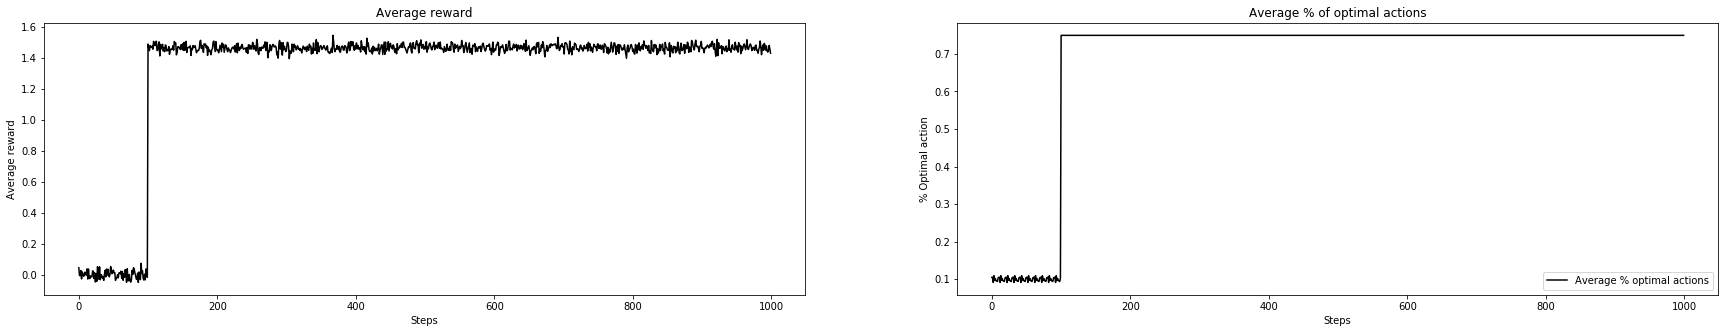

In [88]:
bandit_interactions(ETC_next_action, 10, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function ETC_next_action at 0x00000219B1E37268>  with parameter  80 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


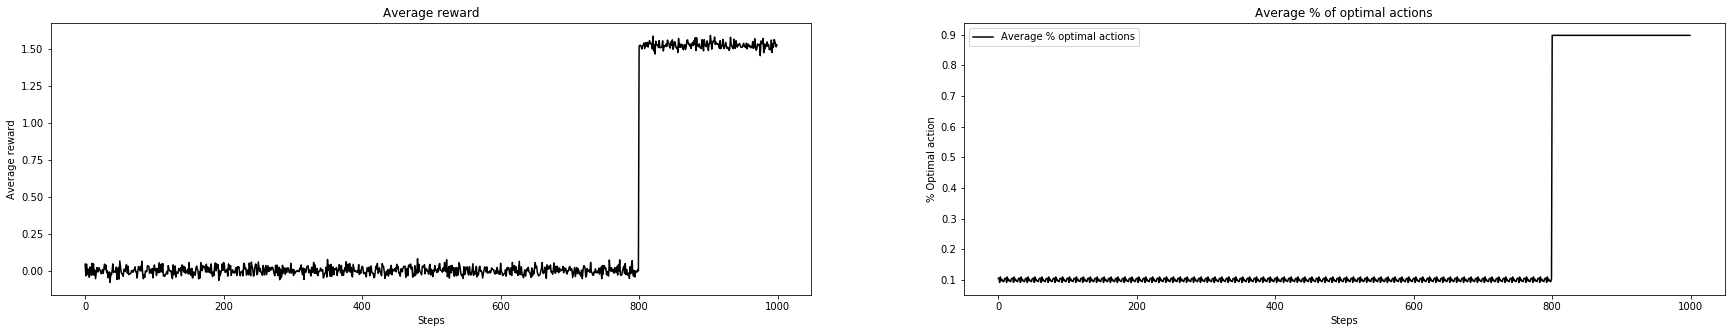

In [99]:
bandit_interactions(ETC_next_action, 80, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function Greedy_next_action at 0x00000219B1E371E0>  with parameter  0.2 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


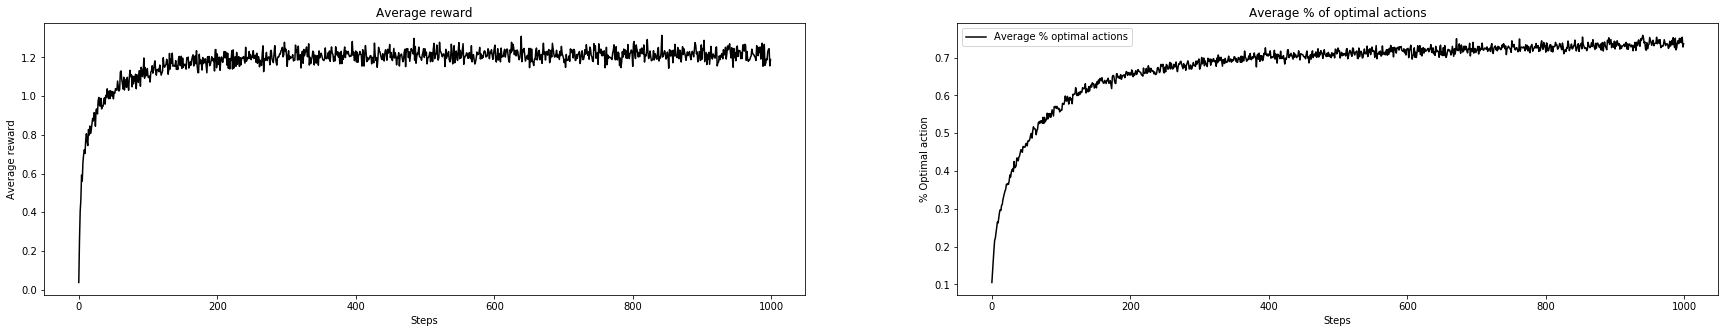

In [100]:
bandit_interactions(Greedy_next_action, 0.2, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function Greedy_next_action at 0x00000219B1E371E0>  with parameter  0.1 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


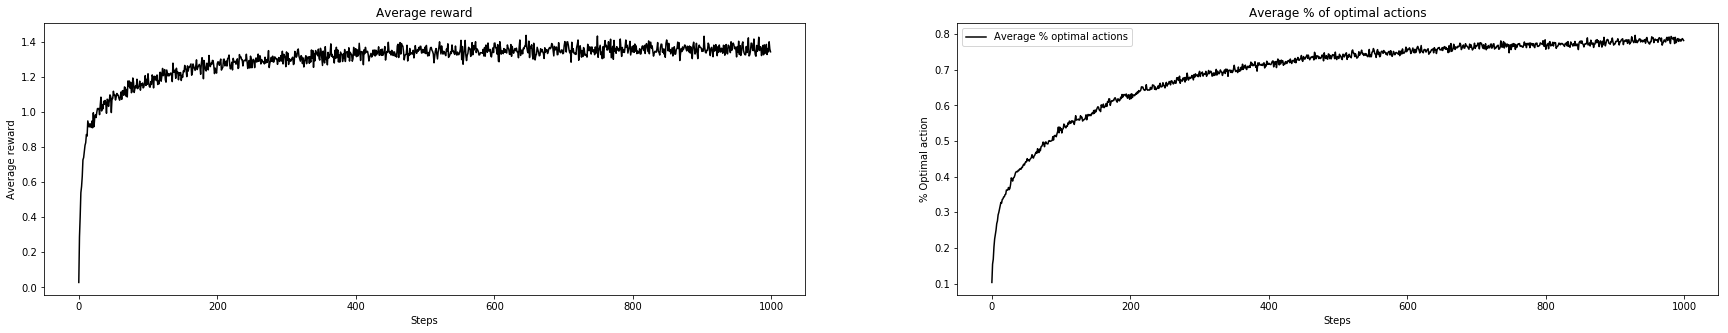

In [96]:
bandit_interactions(Greedy_next_action, 0.1, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function Greedy_next_action at 0x00000219B1E371E0>  with parameter  0.01 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


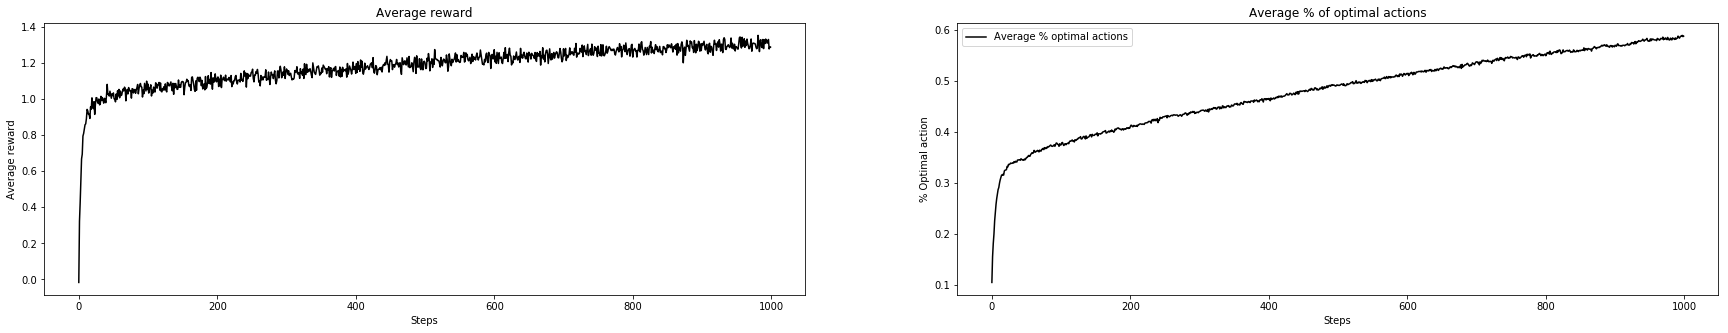

In [90]:
bandit_interactions(Greedy_next_action, 0.01, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function Greedy_next_action at 0x00000219B1E371E0>  with parameter  0 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


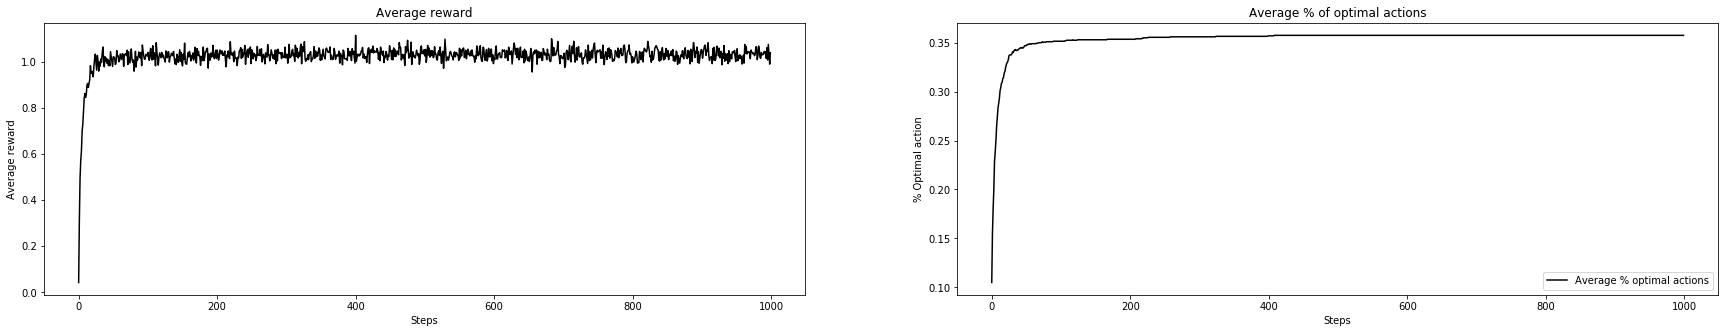

In [91]:
bandit_interactions(Greedy_next_action, 0, sample_average_step, np.zeros(k), horizon, all_means)

Averages over 2000 instances for  <function Greedy_next_action at 0x00000219B1E371E0>  with parameter  0 and initial values  5.0  and weighted average  <function const_step at 0x00000219B2350730>


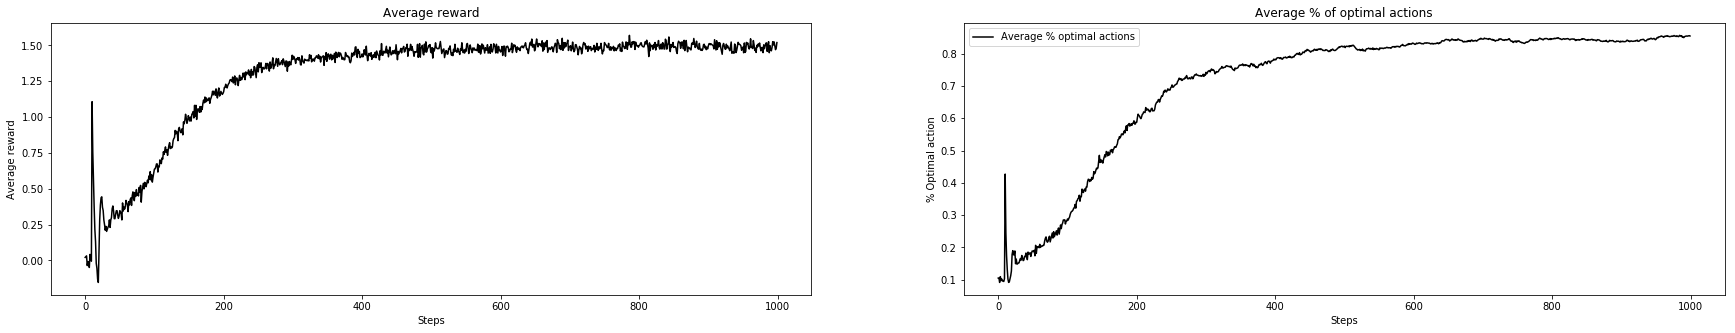

In [92]:
bandit_interactions(Greedy_next_action, 0, const_step, 5*np.ones(k), horizon, all_means)

Averages over 2000 instances for  <function UCB_next_action at 0x00000219B191FE18>  with parameter  2 and initial values  0.0  and weighted average  <function sample_average_step at 0x00000219B1E37048>


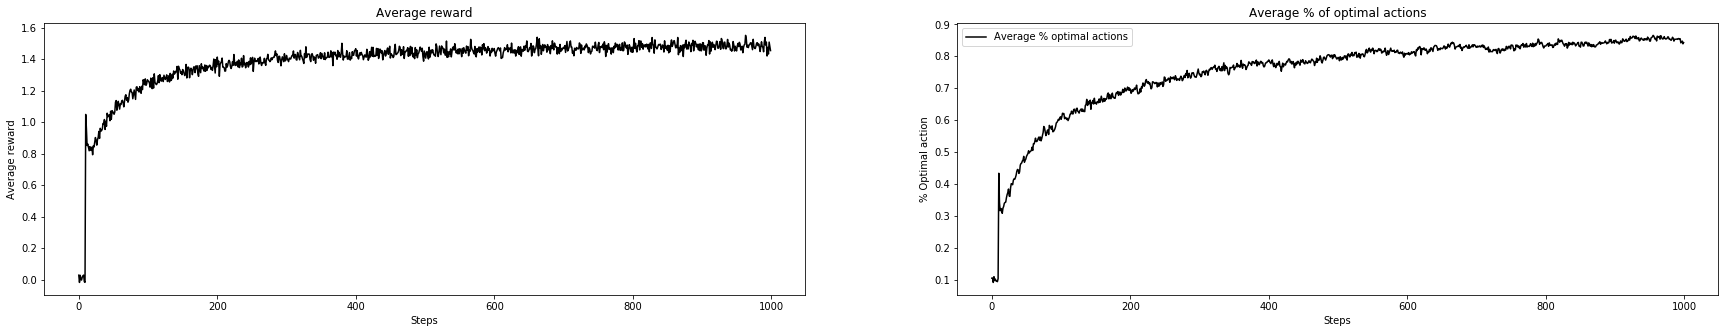

In [103]:
bandit_interactions(UCB_next_action, 2, sample_average_step, np.zeros(k), horizon, all_means)

### Interpret your result:
How do you interpret the behaviour observed for the different strategies on the 10-armed testbed? Write at least three observations that you can make.

- Observation 1: For the explore then commit strategy we see that during the 10 initial pulls for each arm, the reward is low. After the exploring phase the reward increases drastically and stabilizes. The best arm will not always be the one with the highest action-value after the 10 initial pulls. Therefore 
- Observation 2: For the epsilon-greedy strategy we see that the random exploration leads to higher reward in the beginning than ETC, but it converges faster than ETC. The choice of epsilon is important here. Too small and it will converge very slowly, and if it is too large the percentage of optimal action will be lower because the strategy explores too much. We also see that no exploration leads to a very low percentage of optimal actions.
- Observation 3: The UCB strategy is also able to get a fairly high rate of optimal actions, and it converges reasonably quickly as well. The only strategy i am able to receive a higher rate of optimal actions with is ETC with many initial pulls. This is expected as the action value of each arm will get closer to the real value the more you pull the arm. 

## 6) Group Projects

Please indicate here whether you plan to do the course project and if so:
- Are you studying at Masters/PhD/Bachelors level? If you are a Masters/Bachelors Student: Who will be your group partner? (You can find partners e.g., via the discussion forum on Canvas!)
- Suggest a topic (e.g. based on a paper or book chapter) and/or indicate preferences over at least 5 topics from the list below. Coordinate this with your group partner if you have one! Is there a topic that connects particularly well with your PhD or Masters thesis topic?
- It will be possible to prepare a video instead of giving a life presentation. Please indicate if you are interested in this option.
- If you want to give  live presentation, do you have any restrictions on when you can present you topic in the course? Suggested dates can be found in the course schedule marked as "Project Presentations". 

Here are some thoughts on possible topics: 
1. Chapter 8 of Sutton & Barto: Planning and Learning with Tabular Methods
2. Asynchronous and Real-time Dynamic Programming Methods (chapter 8.7 together with this source seems good: https://web.cs.umass.edu/publication/docs/1991/UM-CS-1991-057.pdf) 
3. Inverse Reinforcement Learning paper from Russell and Ng (2000): https://ai.stanford.edu/~ang/papers/icml00-irl.pdf and maybe the survey as support https://arxiv.org/pdf/1806.06877.pdf
4. Bayesian Reinforcement Learning and Thompson sampling: Section 1-3 in https://arxiv.org/pdf/1609.04436.pdf and Section 1-3 in https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf
5. Combinatorial Bandits or Contextual Bandits
6. Dueling Bandits e.g. based on this survey https://www.ijcai.org/proceedings/2018/0776.pdf
7. Monte Carlo tree search (any specific topic from http://www.incompleteideas.net/609\%20dropbox/other\%20readings\%20and\%20resources/MCTS-survey.pdf)
8. Alpha Go Paper https://www.researchgate.net/publication/292074166_Mastering_the_game_of_Go_with_deep_neural_networks_and_tree_search
9. Policy Gradient Methods Chapter 13 and in particular REINFORCE/Actor-Critic
10. Chapter 15 Neuroscience (also includes Actor-Critic in overlap with Chapter 13)  

A bit more practical topics:  

11. An overview of the openAI Gym https://gym.openai.com/: what are the available features and environments and what can they be used for/ how can they be used - give a tutorial!
12. An overview of MushroomRL https://mushroomrl.readthedocs.io/en/latest/: what are the available features and algorithms and what can they be used for/ how can they be used - give a tutorial!
13. Kaggle Santa 2020 - The Candy Cane Contest https://www.kaggle.com/c/santa-2020: Review the problem (in terms of known bandit problem features) and (critically) describe some approaches to the problem by some participants

I am studying at master's level, and my group partner for the project will be Marcus Moen.
We would like on of the topics 4,3,2,7 or 6. This is the order we prefer as well. We want to have the talk live and preferably around May 10th.